# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo_Training.ipynb

---

### Requirements

In [1]:
!git clone https://github.com/bao18/open_earth_map.git

In [2]:
!pip install rasterio

In [ ]:
import os
import gdown
import zipfile

url = "https://drive.google.com/uc?id=1PQvlAg3bdQQvlAq1RtQ-_boax-WObSU4"
output = "OpenEathMap_Mini.zip"
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("data")
os.remove(output)

### Imports
---

In [10]:
import time
import warnings
import numpy as np
import torch
import open_earth_map.oem as oem
import torchvision
from pathlib import Path

warnings.filterwarnings("ignore")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Defines main parameters

In [11]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/home/bruno/riken_openearthmap/LULC-RIKEN/integrated"

# Training and validation file list
TRAIN_LIST = "data/train_mini.txt"
VAL_LIST = "data/val_mini.txt"

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 50
DEVICE = "cuda"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepares training and validation file lists.

In [3]:
img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in img_paths if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(img_paths))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

NameError: name 'Path' is not defined

### Prepares training and validation file lists.

In [4]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Defines data augmentations for training and validation sets

In [ ]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Defines training and validation dataloaders

In [ ]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 410
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

## Defines the network architecture, optimizer, and criterion

In [5]:
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.JaccardLoss()

Loaded model:model.pth (Epoch=19, Score=0.185)


## Trains and validates the network

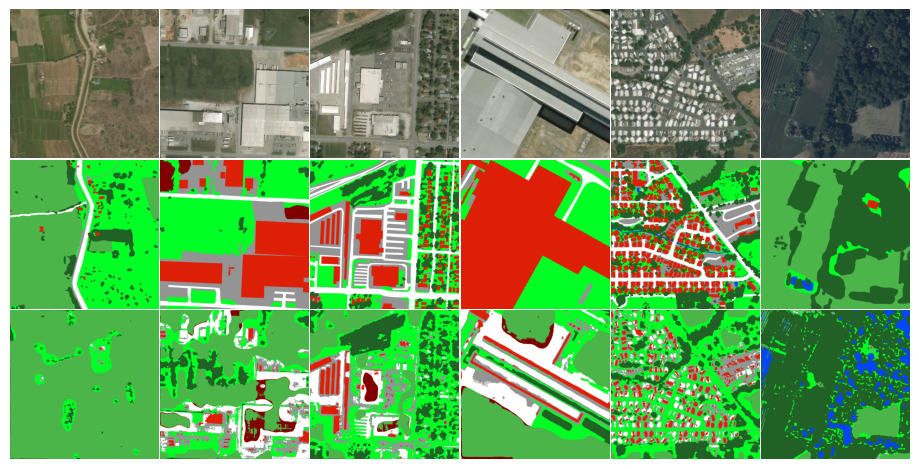

In [12]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))